In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
import py_rdl
import RA

# Substituents Orientation

In [87]:
# Substituents
aliphatic = [len(aliphatic_fluorine),len(aliphatic_chlorine),len(aliphatic_bromine), len(aliphatic_iodine), 
             len(aliphatic_alkoxy), len(aliphatic_hydroxyl), len(aliphatic_amine0),len(aliphatic_amine1)
             ,len(aliphatic_amine2), len(aliphatic_methyl)]
aromatic = [len(aromatic_fluorine),len(aromatic_chlorine),len(aromatic_bromine), len(aromatic_iodine), 
           len(aromatic_alkoxy), len(aromatic_hydroxyl), len(aromatic_amine0), len(aromatic_amine1),
            len(aromatic_amine2), len(aromatic_methyl)]
types = ["aliphatic"]*len(aliphatic) + ["aromatic"]*len(aromatic)
name = ["Fluorine","Chlorine","Bromine","Iodine","Alkoxy","Hydroxyl","Tertiary Amine","Secondary Amine","Primary Amine", 
        "Methyl"]

In [88]:
dataframe = pd.DataFrame({"Types":types,"Count":aliphatic+aromatic, "Name":name*2})

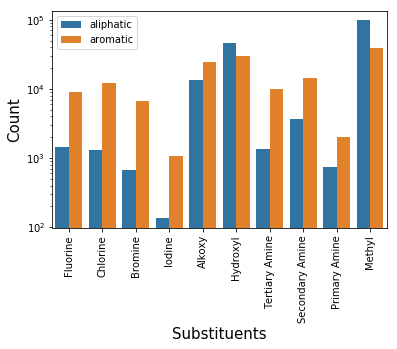

In [89]:
sns.barplot(x="Name",y="Count", data=dataframe, hue="Types")
plt.yscale("log")
plt.xticks(range(len(name)), name, rotation='vertical')
plt.xlabel("Substituents",size=15)
plt.ylabel("Count",size=15)
plt.legend()
plt.show()

In [53]:
fluorine = pd.read_csv("data/halogen_f.csv")
chlorine = pd.read_csv("data/halogen_cl.csv")
bromine = pd.read_csv("data/halogen_br.csv")
iodine = pd.read_csv("data/halogen_i.csv")

In [54]:
aromatic_fluorine = fluorine[fluorine["aromatic"]==True]
aliphatic_fluorine = fluorine[fluorine["aromatic"]==False]

aromatic_chlorine = chlorine[chlorine["aromatic"]==True]
aliphatic_chlorine = chlorine[chlorine["aromatic"]==False]

aromatic_bromine = bromine[bromine["aromatic"]==True]
aliphatic_bromine = bromine[bromine["aromatic"]==False]

aromatic_iodine = iodine[iodine["aromatic"]==True]
aliphatic_iodine = iodine[iodine["aromatic"]==False]

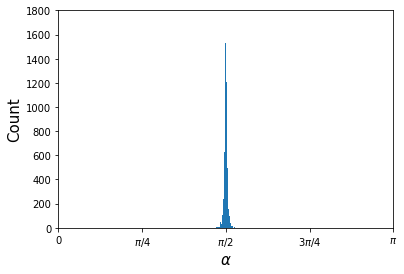

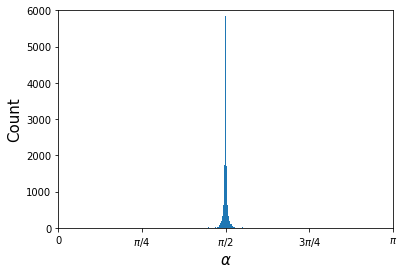

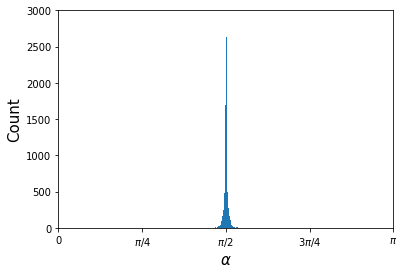

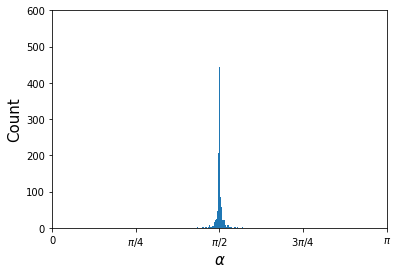

In [129]:
plt.hist(aromatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,1800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_flurine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,6000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,3000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

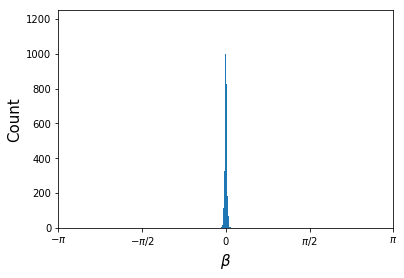

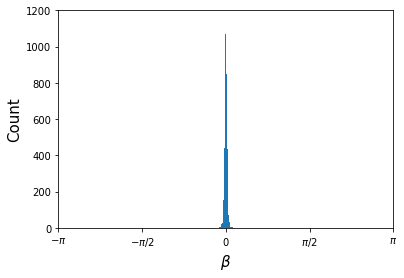

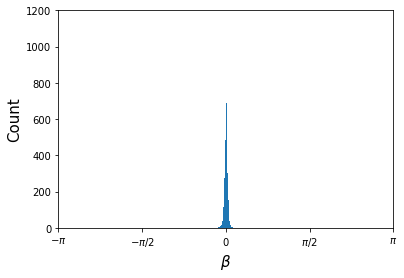

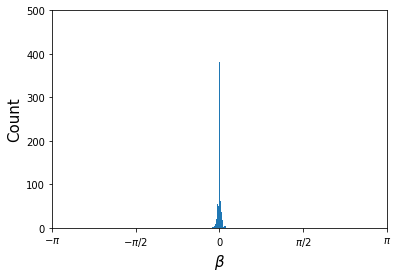

In [131]:
plt.hist(aromatic_fluorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1250)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

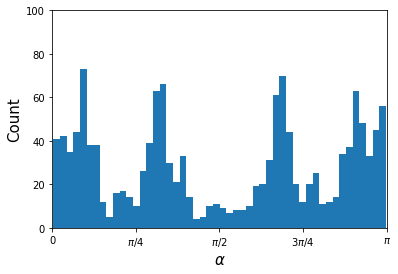

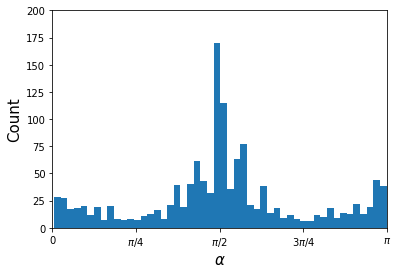

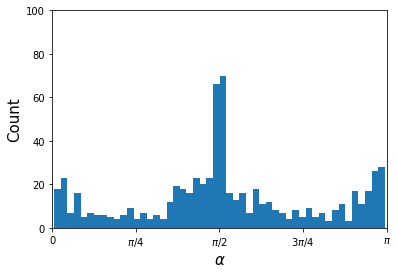

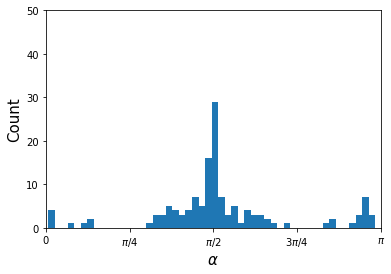

In [135]:
plt.hist(aliphatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

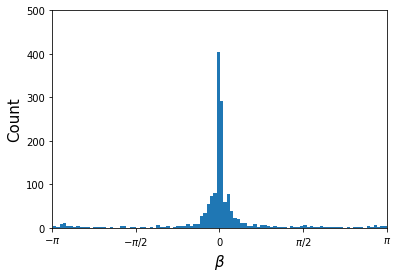

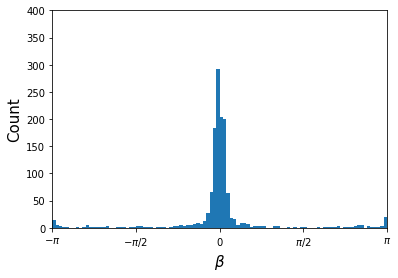

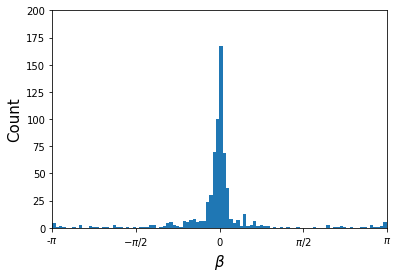

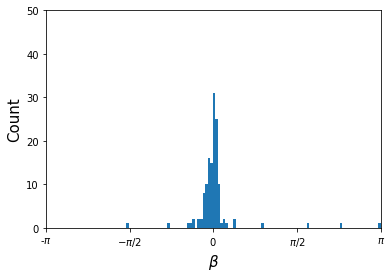

In [132]:
plt.hist(aliphatic_fluorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,400)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Methyl

In [43]:
methyl = pd.read_csv("data/methyl.csv")

aromatic_methyl = methyl[methyl["aromatic"]==True]
aliphatic_methyl = methyl[methyl["aromatic"]==False]

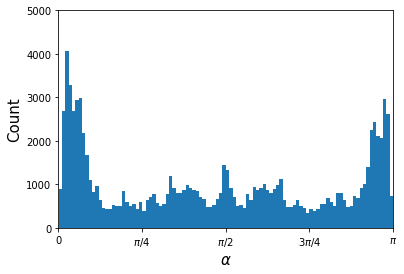

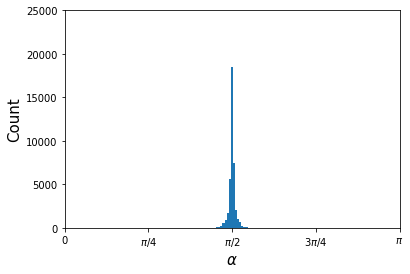

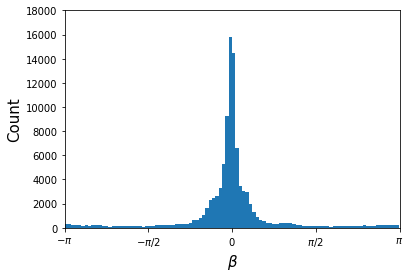

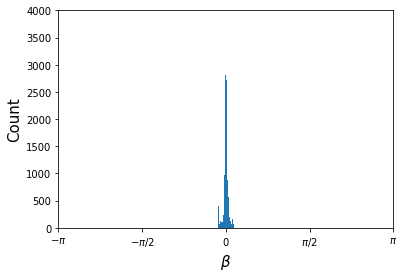

In [44]:
plt.hist(aliphatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,5000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,25000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,18000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Alkoxy and Hydroxyl

In [45]:
alkoxy = pd.read_csv("data/alkoxy.csv")
hydroxyl = pd.read_csv("data/hydroxyl.csv")

aromatic_alkoxy = alkoxy[alkoxy["aromatic"]==True]
aliphatic_alkoxy = alkoxy[alkoxy["aromatic"]==False]

aromatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==True]
aliphatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==False]

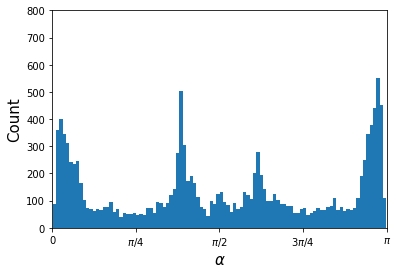

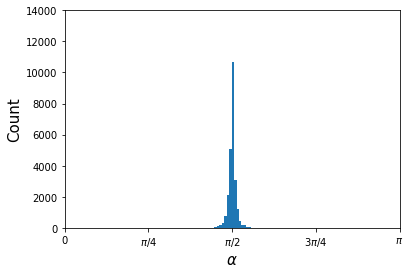

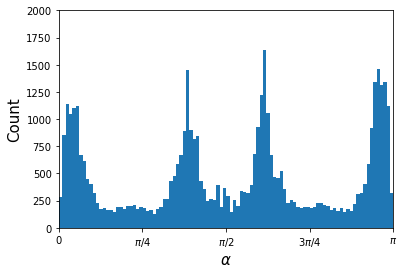

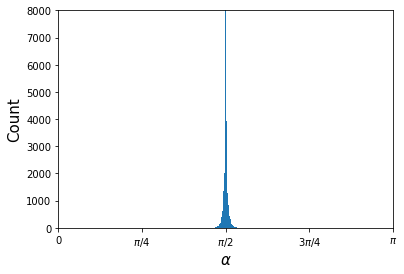

In [47]:
plt.hist(aliphatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,14000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,8000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


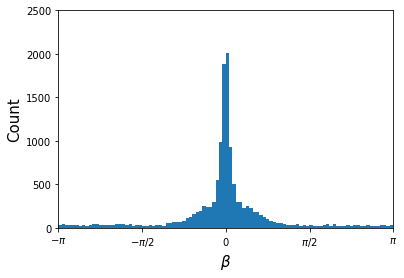

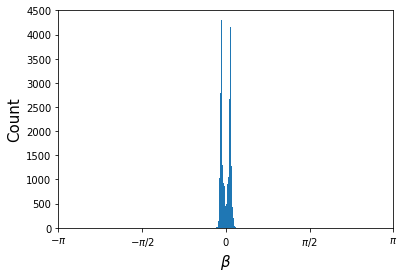

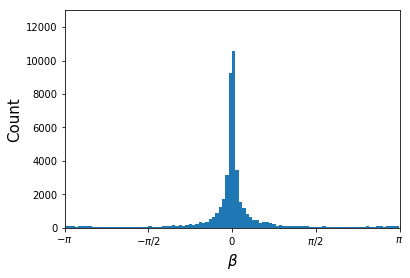

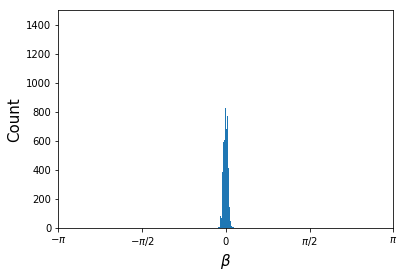

In [48]:
plt.hist(aliphatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,2500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,13000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Amine

In [4]:
amine0 = pd.read_csv("data/amine_0.csv")
amine1 = pd.read_csv("data/amine_1.csv")
amine2 = pd.read_csv("data/amine_2.csv")


aromatic_amine0 = amine0[amine0["aromatic"]==True]
aliphatic_amine0 = amine0[amine0["aromatic"]==False]

aromatic_amine1 = amine1[amine1["aromatic"]==True]
aliphatic_amine1 = amine1[amine1["aromatic"]==False]

aromatic_amine2 = amine2[amine2["aromatic"]==True]
aliphatic_amine2 = amine2[amine2["aromatic"]==False]

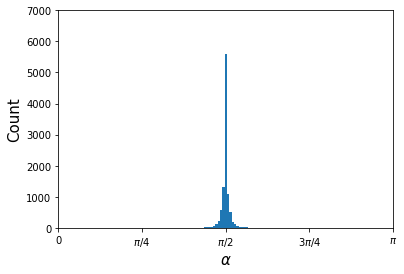

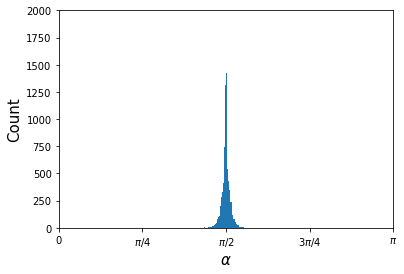

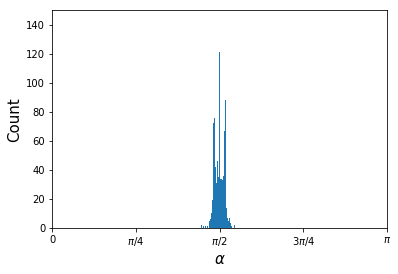

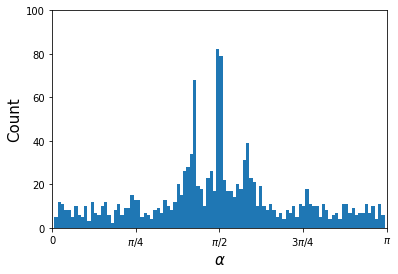

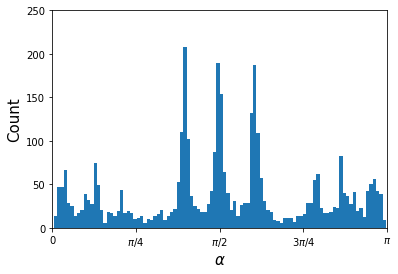

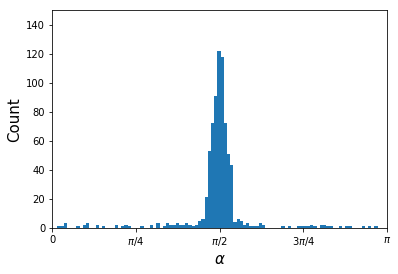

In [40]:
## Aromatic
plt.hist(aromatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,7000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


plt.hist(aliphatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,250)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()



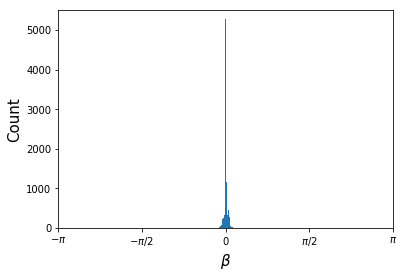

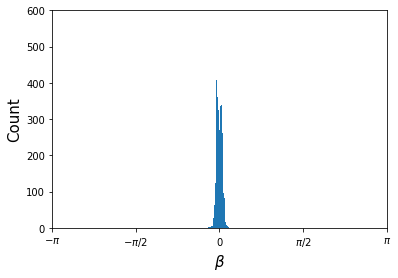

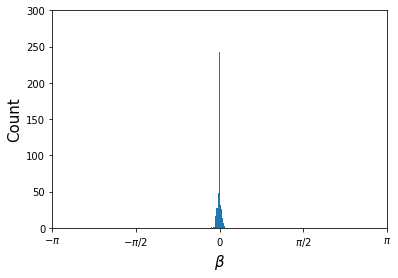

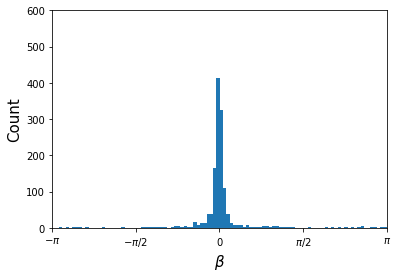

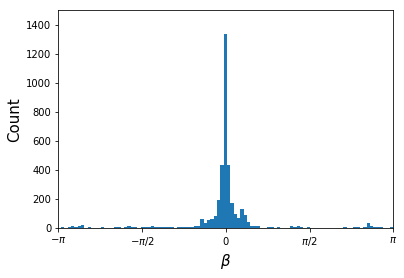

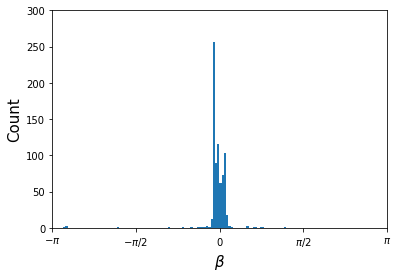

In [41]:
## Aromatic
plt.hist(aromatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

## Aliphatic
plt.hist(aliphatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [3]:
alkoxy = Chem.SDMolSupplier("molecule/f.sdf")
alkoxy_smarts = "[R][F&!R]"
c1 = []
for idx, mol in enumerate(alkoxy):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if (len(list(rc.nodes))<20) and (len(list(rc.nodes))>4):
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ox = RA.GetSubstituent(mol, list(rc.nodes), alkoxy_smarts)
                if any(ox):
                    for i in ox:
                        ccoord = RA.Translate(coord)
                        cptmp = RA.GetRingPuckerCoords(ccoord)
                        ohpos = RA.GetRingSubstituentPosition(mol, ringloop, i)
                        b = RA.GetRingBonds(mol, ringloop)
                        c1.append((idx,cptmp,ohpos,b))
